In [1]:
import tensorflow.keras as keras
keras.__version__

"""
Allocate only as much GPU memory as needed for the runtime allocations.
"""
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

This notebook is inspired by official TensorFlow Tutorial https://www.tensorflow.org/tutorials/generative/deepdream

# DeepDream

DeepDream is an artistic image-modification technique that uses the representations learned by convolutional nerual networks. 

The DeepDream algorithm is almost identical to the convent filter-visualization technique, consiting of running a convnet in reverse: doing gradient ascent on the input to the convnet in order to maximize the activation of a specific filter in an upper layer of the convent. DeepDream uses this same idea, with a few simple differences:

- With DeepDream, you try to maximize the activation of entire layers rather than that of a specific filter, thus mixing together visualizations of large numbers of features at once.
- You start not from blank, slightly noisy input, but rather from an existing image -- thus the resulting effects latch on to preexisting visual patterns, distroting elements of the image in a somewhat artistic fashion.
- The input images are processed at different scales (called octaves), which improves the quality of the visualizations.

## Implementing DeepDream in Keras

We will start from a convnet pre-trained on ImageNet. In Keras, we have many such convnets available: VGG16, VGG19, Xception, ResNet50... albeit the same process is doable with any of these, `your convnet of choice will naturally affect your visualizations`, since `different convnet architectures result in different learned features`. The convnet used in the original Deep Dream release was an Inception model, and in practice Inception is known to produce very nice-looking Deep Dreams, so we will use the InceptionV3 model that comes with Keras.

In [2]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

model.summary()

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3

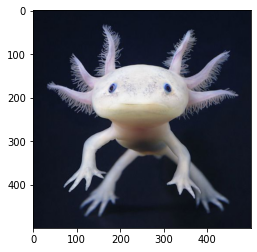

In [11]:
img_path = 'axolotl.jpg'

import IPython.display as display
import PIL.Image
from keras.preprocessing import image
import numpy as np

# Normalize an image for show.
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Load an image
img = image.load_img(img_path, target_size=(500, 500))
img_tensor = image.img_to_array(img, dtype=np.uint8)

import matplotlib.pyplot as plt
plt.imshow(img_tensor)
plt.show()

## Compute loss

Next, we compute the "loss", the quantity that we will maximize during the gradient ascent process. In Chapter 5, for filter visualization, we were trying to maximize the value of a specific filter in a specific layer. Here we will `simultaneously "maximize" the activation of all filters in a number of layers` (`activation of all filters --> loss`). Specifically, we will maximize a weighted sum of the L2 norm of the activations of a set of high-level layers. 

The exact set of layers we pick (as well as their contribution to the final loss) has a large influence on the visuals that we will be able to produce, so we want to make these parameters easily configurable. Lower layers result in geometric patterns, while higher layers result in visuals in which you can recognize some classes from ImageNet (e.g. birds or dogs). We'll start from a somewhat arbitrary configuration involving four layers -- but you will definitely want to explore many different configurations later on:

The layers of interest are the activations which will contribute to the loss we will seek to maximize. In InceptionV3, they are named 'mixed??'.

- Different layers will result in different dream-like images.
- Modifying deeper layers will take longer to train since the gradient computation is deeper.

In [4]:
# Maximize the activations of those layers
names = ['mixed3', 'mixed5']
layers = [model.get_layer(name).output for name in names]

# Create the feature extraction model, 
# which is a submodel containing all layers between the input layers 
# and highest layer in "names".
dream_model = tf.keras.Model(inputs=model.input, outputs=layers)

dream_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []

    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

## Gradient ascent

1. Compute loss for the chosen layer
2. Calculate the gradients wrt to the image
3. Add the gradients to the original image.

Adding the gardients to the image enhances the patterns seen by the network. Essentially, we are creating an image that increasingly excites the activation of certain layers in the network.

In [7]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    # Wrapped in a tf.function for performance.
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that 
            # the input image increasingly "excites" the layers.
            # Inversely, for gradient descent, img=img-gradients*step_size.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [8]:
"""
Create a DeepDream instance
"""
ddInstance = DeepDream(dream_model)

## Start dreaming

In [14]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = ddInstance(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        display.display(PIL.Image.fromarray(np.array(deprocess(img))))

        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(np.array(result)))

    return result

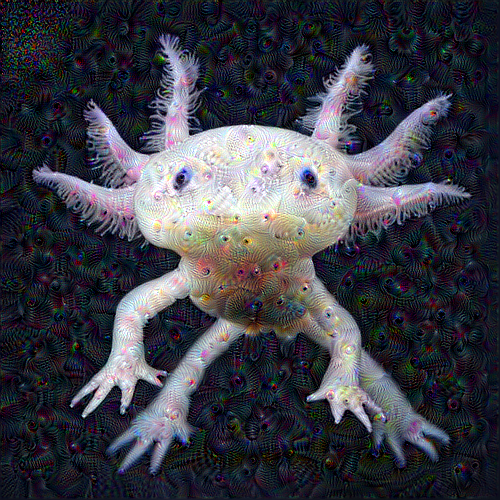

In [15]:
dream_img = run_deep_dream_simple(
    img=img_tensor, 
    steps=100, step_size=0.01
)


## Taking it up an octave

Pretty good, but there are a few issues with this first attempt:

- The output is noisy (this could be addressed with a tf.image.total_variation loss);
- The image is low resolution;
- The patterns appear like they're all happening at the same granularity;

One approach that addresses all these problems is `applying gradient ascent at different scales`. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this we can perform the previous gradient ascent approach, then `increase the size of the image` (which is referred to as an octave), and repeat this process for multiple octaves.

**It is like a `fractal generation`!!!!**


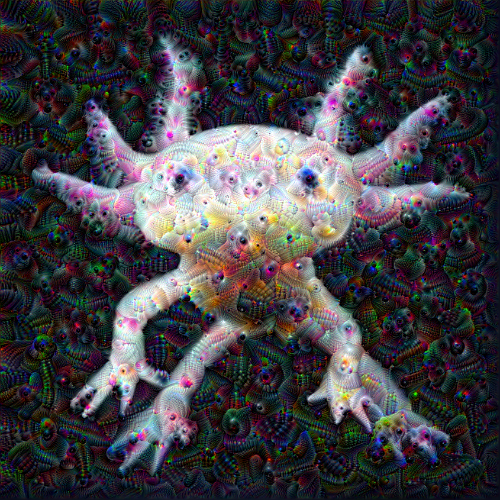

9.875907897949219

In [23]:
import time

start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(img_tensor))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
display.display(PIL.Image.fromarray(np.array(img)))

end = time.time()
end - start